# Introduction
In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video). This will help us extract topics of discussion. We use the embeddings generated in Assignment 4 as input. (This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/') Each of our comments has been assigned a vector that encodes information about its meaning. The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality. We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them. To do this we reduce the dimensionality of the embeddings again to two dimensions. Then we render a scatterplot of our data.
Furthermore we want to analyze and interpret our clusters. To do this, we:

print some statistics about each of the clusters
print cluster's medoid (the central sample)
print the cluster(s) we want to analyze further
Check to see if jupyter lab uses the correct python interpreter with '!which python'. It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac). If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!python --version

Python 3.8.5


# Install dependencies:

In [2]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Zaher11\anaconda3

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    umap-learn-0.4.6           |   py38h32f6830_0         111 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38
  tbb                conda-forge/win-64::tbb-2020.1-he980bc4_0
  umap-learn         conda-forge/win-64::umap-learn-0.4.6-py38h32f6830_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda       

# Imports


In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [4]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')

# Set pandas print options
This will improve readability of printed pandas dataframe.

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [6]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe. And load the embeddings as a numpy ndarray (a matrix in our case).

In [7]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [8]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP
We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. The number of dimensions (num_dimensions) depends on the number of samples

In [9]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.47220892
n_clusters: 102 silhouette_avg: 0.34595862
n_clusters: 202 silhouette_avg: 0.3305257
n_clusters: 302 silhouette_avg: 0.31658703
n_clusters: 402 silhouette_avg: 0.29387975
n_clusters: 502 silhouette_avg: 0.26846132
n_clusters: 602 silhouette_avg: 0.2424068
n_clusters: 702 silhouette_avg: 0.19251211
n_clusters: 802 silhouette_avg: 0.14201015
n_clusters: 902 silhouette_avg: 0.09095344


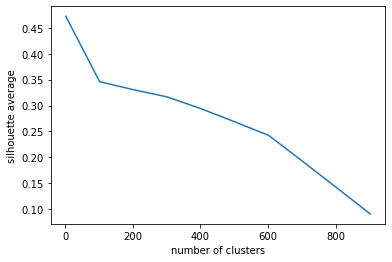

In [10]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [11]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 25     1
14     1
97     1
68     1
83     2
80     2
93     2
90     2
91     2
34     2
56     3
82     3
81     4
49     4
11     5
22     5
41     5
74     5
92     5
52     5
20     5
43     5
89     6
40     6
3      6
10     6
64     6
17     6
32     6
44     6
78     6
99     7
0      7
59     7
18     7
45     7
54     7
67     7
86     7
1      8
96     8
33     8
42     8
94     8
79     8
51     9
98     9
61     9
85     9
35     9
47     9
95    10
30    10
19    10
69    10
70    10
4     10
73    11
28    11
75    11
36    11
15    11
76    11
13    11
62    11
31    11
60    11
87    11
29    11
65    11
7     12
12    12
37    12
24    12
58    13
66    13
9     13
71    14
53    14
21    14
55    14
2     15
16    15
72    15
27    15
23    16
84    16
88    16
39    18
57    18
63    18
48    18
38    19
26    20
46    20
50    24
77    24
5     25
8     29
6     31
Name: label_kmedoids, dtype: int64


In [12]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [13]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_clustering.fit_transform(embeddings)

# Visualize clustering results

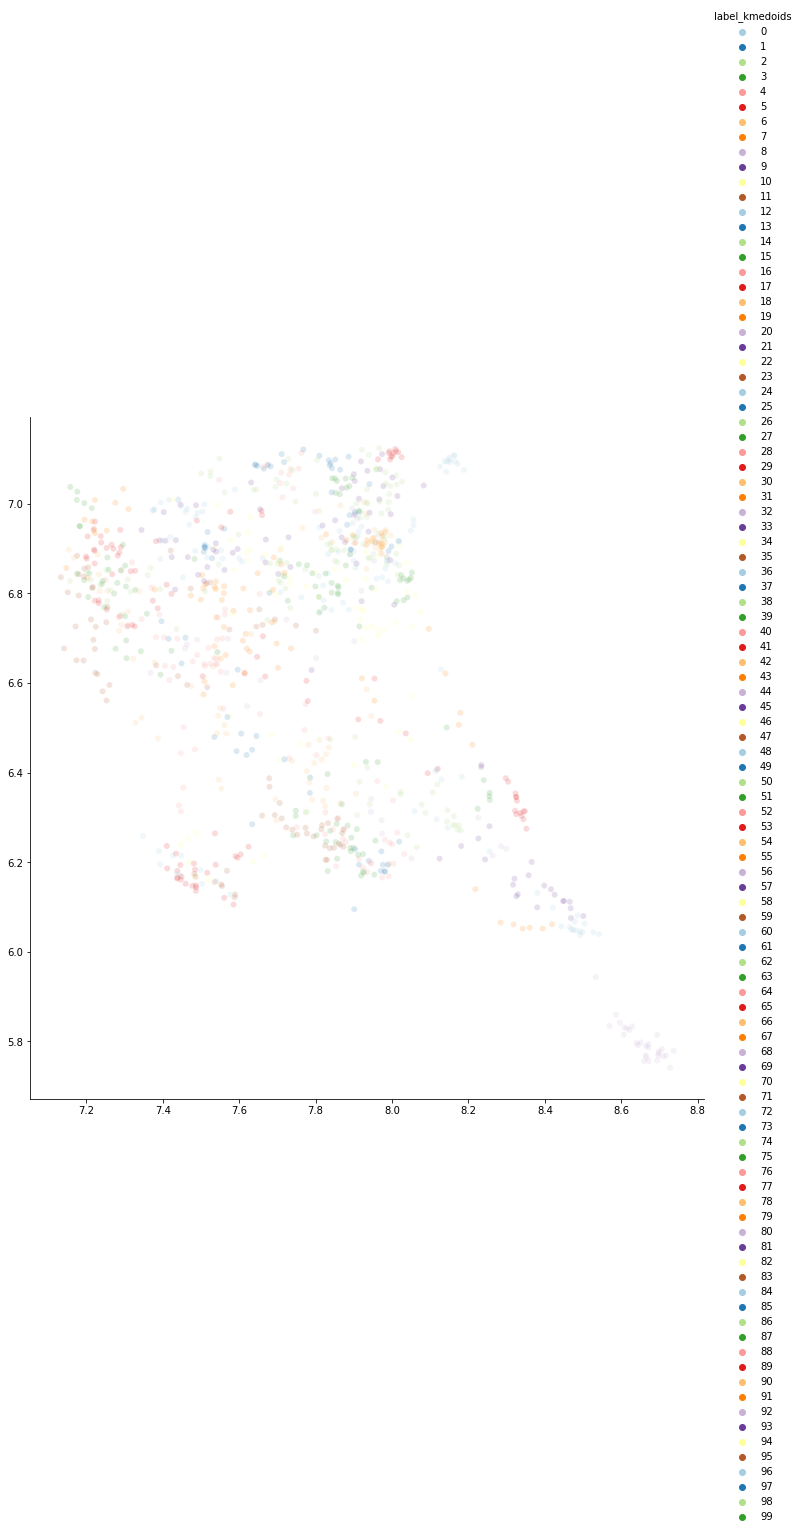

In [14]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Paired" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

# Highlight one cluster

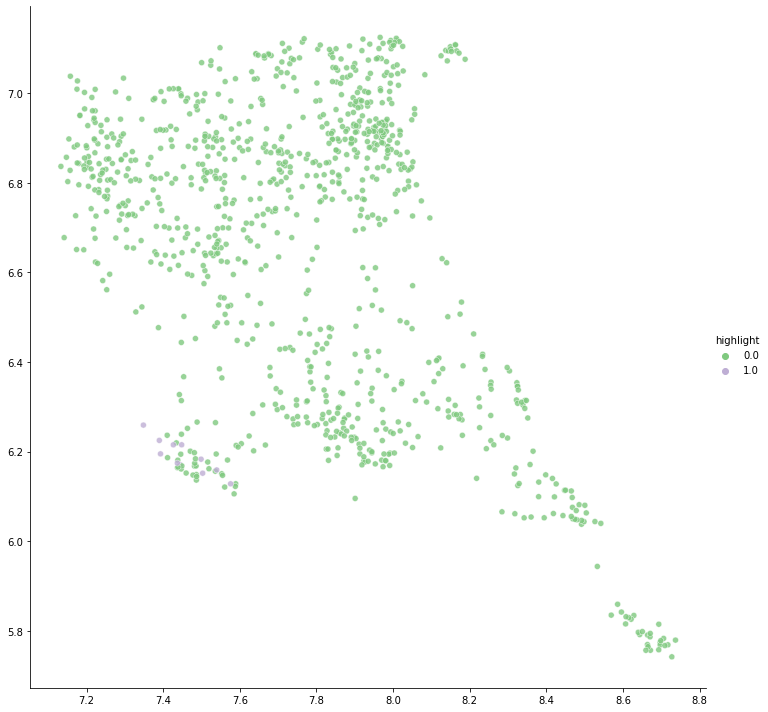

In [15]:
## Choose a cluster to higlight:
cluster_num = 60

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

# Print Medoids and cluster statistics

In [16]:
# print the medoids 
data.iloc[medoids_indices]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1538,2020-04-02 23:03:57,LuckyStriker,"Don is correct, the rest of all y&#39;all are killing us",0,"Don is correct, the rest of all y'all are killing us\n\n",-1.0,0,0.000000e+00,0.0
1551,2020-03-30 17:40:47,Jahangir Mehta,&quot;Threats to western civilization&quot; ? <br />Well that was enough for me to get that she was a RW tinfoil conspiracy theorist who believes in word of mouth and conspiracies rather then facts...................<br />And these people are not called criminals and threats to society hah ? Wow...............,0,"""Threats to western civilization"" ? \nWell that was enough for me to get that she was a RW tinfoil conspiracy\ntheorist who believes in word of mouth and conspiracies rather then\nfacts................... \nAnd these people are not called criminals and threats to society hah ?\nWow...............\n\n",-1.0,1,0.000000e+00,0.0
1975,2020-02-28 15:03:36,Trump 2Q2Q,Stop Chemtrails and HAARP,0,Stop Chemtrails and HAARP\n\n,-1.0,2,0.000000e+00,0.0
1221,2020-04-27 15:45:26,Tardersauce35,I’ve seen that constitution guy enough time to know that I’m not gonna like anything that comes out of his mouth.,0,I’ve seen that constitution guy enough time to know that I’m not gonna like\nanything that comes out of his mouth.\n\n,-1.0,3,0.000000e+00,0.0
1205,2020-04-28 17:33:06,Annabella Doll,"Activists: Lets try and save the world! We can be better, we know its happening, so let&#39;s be held accountable and try and change.<br />Skeptics: (aka. Uneducated people) Money, Money, what happens to our money, what about china, what about our rights, money...",0,"Activists: Lets try and save the world! We can be better, we know its\nhappening, so let's be held accountable and try and change. \nSkeptics: (aka. Uneducated people) Money, Money, what happens to our money,\nwhat about china, what about our rights, money...\n\n",-1.0,4,0.000000e+00,0.0
1111,2020-07-26 15:58:10,Cyberpunk Spinoza,@attatawil socialism does not need a government. In fact it functions better witought a government. But since when is America anti government? You guys loooove the goverment but you dont want it to exist for the people. You want goverment to be around just to help corporations.,1,@ socialism does not need a government. In fact it functions better\nwitought a government. But since when is America anti government? You guys\nloooove the goverment but you dont want it to exist for the people. You want\ngoverment to be around just to help corporations.\n\n,-1.0,5,0.000000e+00,0.0
1381,2020-04-13 03:43:58,Sebastian-Benedict Flore,"<a href=""https://www.youtube.com/watch?v=6EFHZfISGp4&amp;t=4m18s"">4:18</a>",0,4:18\n\n,-1.0,6,0.000000e+00,0.0
1554,2020-03-30 08:52:40,Fluffy Cat,"So the first 2 points the skeptics made were 100% wrong/only thinking about America. They obviously don’t know other countries are trying to help too and shown they haven’t been rightly educated about this.<br /><br />And oh my god here he goes again, I don’t know the name but the black dude figuratively just talks about the US and freedom. It’s not just effecting the US it’s effecting the world that’s why people are doing so much stuff about it.",0,"So the first 2 points the skeptics made were 100% wrong/only thinking about\nAmerica. They obviously don’t know other countries are trying to help too and\nshown they haven’t been rightly educated about this. \n \nAnd oh my god here he goes again, I don’t know the name but the black dude\nfiguratively just talks about the US and freedom. It’s not just effecting the\nUS it’s effecting the world that’s why people are doing so much stuff about\nit.\n\n",-1.0,7,0.000000e+00,0.0
1142,2020-09-16 21:02:15,Jake,@Andrew Harron I am libertarian for almost every single thing except I am against legalized genocide. Murder is murder no matter how small. I oppose abortion of any kind but I am extremely libertarian. I even want to abolish pub

In [17]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  7 mean distance from center:  0.0015624931620550342 Proportion of replies: 57.142857142857146
1 number of samples:  8 mean distance from center:  0.00025406479835510254 Proportion of replies: 0.0
2 number of samples:  15 mean distance from center:  0.0015823046851437539 Proportion of replies: 26.666666666666668
3 number of samples:  6 mean distance from center:  0.0006198883056640625 Proportion of replies: 0.0
4 number of samples:  10 mean distance from center:  0.0029534101486206055 Proportion of replies: 10.0
5 number of samples:  25 mean distance from center:  0.0007543563697254285 Proportion of replies: 96.0
6 number of samples:  31 mean distance from center:  0.00029110140076227253 Proportion of replies: 83.87096774193549
7 number of samples:  12 mean distance from center:  0.0008543332114641089 Proportion of replies: 8.333333333333334
8 number of samples:  29 mean distance from center:  0.0004213431566313375 Proportion of replies: 96.55172413793103
9 number 

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [18]:
# Choose a cluster to print
cluster_number =   60
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 11
Average Distance from cluster center: 7.125464435375761e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1677,2020-03-19 07:41:25,HL65536,Totally revolutionary idea: How about doing something about climate change without socialism? Paying for the damage you cause is a really easy solution that is totally compatible with capitalism.,0,Totally revolutionary idea: How about doing something about climate change\nwithout socialism? Paying for the damage you cause is a really easy solution\nthat is totally compatible with capitalism.\n\n,-1.0,60,0.000000,1.0
1590,2020-07-27 01:55:37,Mike Asllani,"Preventing climate change is actually helpful, socialism isn't",1,"Preventing climate change is actually helpful, socialism isn't\n\n",-1.0,60,0.000001,1.0
1619,2020-04-11 20:25:11,Denman Fite,@Connor Lindaur again man this has nothing to do with my position on climate change so stop trying to use that as a strawman. I'm referencing socialism and it's relationship with climate change.,1,@ again man this has nothing to do with my position on climate\nchange so stop trying to use that as a strawman. I'm referencing socialism and\nit's relationship with climate change.\n\n,-1.0,60,0.000002,1.0
1583,2020-08-30 22:50:30,Connor Lindaur,@Shane Garcia there’s a difference between helping to prevent climate change and giving the government all control. On top of that socialism does not mean a dictatorship or complete government control so allowing the government to help us save the environment does not mean socialism. I’m not saying give the government complete control. I’m saying allow the government to help with protecting the environment instead of just outright calling it oppression.,1,@ there’s a difference between helping to prevent climate change\nand giving the government all control. On top of that socialism does not mean\na dictatorship or complete government control so allowing the government to\nhelp us save the environment does not mean socialism. I’m not saying give the\ngovernment complete control. I’m saying allow the government to help with\nprotecting the environment instead of just outright calling it oppression.\n\n,-1.0,60,0.000004,1.0
1575,2020-11-03 09:14:18,Mariam Said,“socialism is when climate change prevention” - karl marx,1,“socialism is when climate change prevention” - karl marx\n\n,-1.0,60,0.000004,1.0
1783,2020-03-07 21:53:59,Alvarez,"<a href=""https://www.youtube.com/watch?v=6EFHZfISGp4&amp;t=12m16s"">12:16</a> Topic climate change <br />Michael : Socialism 🥴",0,12:16 Topic climate change \nMichael : Socialism 🥴\n\n,-1.0,60,0.000005,1.0
1609,2020-04-16 01:53:16,Abel Duarte,hi everyone I am a socialist. wanting to prevent climate change isn't what makes me a socialist. Lots of socialists like me want to prevent climate change because it is a negative effect of capitalism.,1,hi everyone I am a socialist. wanting to prevent climate change isn't what\nmakes me a socialist. Lots of socialists like me want to prevent climate\nchange because it is a negative effect of capitalism.\n\n,-1.0,60,0.000007,1.0
1262,2020-04-21 21:22:15,Mad Med,"I agree with Michael actually, more regulations and more laws that force people into something, ultimately lead to a socialist country, it&#39;s only a matter of time, I&#39;m not saying I don&#39;t recognize global warming as true or not, I just believe that it&#39;s the free market and the people that should make the choices to preserve the environment, not government policies or regulations.",0,"I agree with Michael actually, more regulations and more laws that force\npeople into something, ultimately lead to a socialist country, it's only a\nmatter of time, I'm not saying I don't recognize global warming as true or\nnot, I just believe that it's the free market and the people that should make\nthe choices to preserve the environment, not government policies or\nregulations.\n\n",-1.0,60,0.000008,1.0
1605,2020-05-01 03:34:18,MegaKonradb,"I share your viewpoint. I'm a supporter of a free mark

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to? min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label label_manual: your label

In [19]:
#which cluster would you like to assign labels to?
cluster_number = 60
#your label
label_manual = ' climate_change_prevention'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [20]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1677,2020-03-19 07:41:25,HL65536,Totally revolutionary idea: How about doing something about climate change without socialism? Paying for the damage you cause is a really easy solution that is totally compatible with capitalism.,0,Totally revolutionary idea: How about doing something about climate change\nwithout socialism? Paying for the damage you cause is a really easy solution\nthat is totally compatible with capitalism.\n\n,climate_change_prevention,60,0.000000,1.0
1590,2020-07-27 01:55:37,Mike Asllani,"Preventing climate change is actually helpful, socialism isn't",1,"Preventing climate change is actually helpful, socialism isn't\n\n",climate_change_prevention,60,0.000001,1.0
1619,2020-04-11 20:25:11,Denman Fite,@Connor Lindaur again man this has nothing to do with my position on climate change so stop trying to use that as a strawman. I'm referencing socialism and it's relationship with climate change.,1,@ again man this has nothing to do with my position on climate\nchange so stop trying to use that as a strawman. I'm referencing socialism and\nit's relationship with climate change.\n\n,climate_change_prevention,60,0.000002,1.0
1583,2020-08-30 22:50:30,Connor Lindaur,@Shane Garcia there’s a difference between helping to prevent climate change and giving the government all control. On top of that socialism does not mean a dictatorship or complete government control so allowing the government to help us save the environment does not mean socialism. I’m not saying give the government complete control. I’m saying allow the government to help with protecting the environment instead of just outright calling it oppression.,1,@ there’s a difference between helping to prevent climate change\nand giving the government all control. On top of that socialism does not mean\na dictatorship or complete government control so allowing the government to\nhelp us save the environment does not mean socialism. I’m not saying give the\ngovernment complete control. I’m saying allow the government to help with\nprotecting the environment instead of just outright calling it oppression.\n\n,climate_change_prevention,60,0.000004,1.0
1575,2020-11-03 09:14:18,Mariam Said,“socialism is when climate change prevention” - karl marx,1,“socialism is when climate change prevention” - karl marx\n\n,climate_change_prevention,60,0.000004,1.0
1783,2020-03-07 21:53:59,Alvarez,"<a href=""https://www.youtube.com/watch?v=6EFHZfISGp4&amp;t=12m16s"">12:16</a> Topic climate change <br />Michael : Socialism 🥴",0,12:16 Topic climate change \nMichael : Socialism 🥴\n\n,climate_change_prevention,60,0.000005,1.0
1609,2020-04-16 01:53:16,Abel Duarte,hi everyone I am a socialist. wanting to prevent climate change isn't what makes me a socialist. Lots of socialists like me want to prevent climate change because it is a negative effect of capitalism.,1,hi everyone I am a socialist. wanting to prevent climate change isn't what\nmakes me a socialist. Lots of socialists like me want to prevent climate\nchange because it is a negative effect of capitalism.\n\n,climate_change_prevention,60,0.000007,1.0
1262,2020-04-21 21:22:15,Mad Med,"I agree with Michael actually, more regulations and more laws that force people into something, ultimately lead to a socialist country, it&#39;s only a matter of time, I&#39;m not saying I don&#39;t recognize global warming as true or not, I just believe that it&#39;s the free market and the people that should make the choices to preserve the environment, not government policies or regulations.",0,"I agree with Michael actually, more regulations and more laws that force\npeople into something, ultimately lead to a socialist country, it's only a\nmatter of time, I'm not saying I don't recognize global warming as true or\nnot, I just believe that it's the free market and the people that should make\nthe choices to preserve the environment, not governme

# Print Cluster 2

In [21]:
# Choose a cluster to print
cluster_number =  64
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 6
Average Distance from cluster center: 1.1771917343139648e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1514,2020-04-07 03:00:34,JOANNA K,"As soon as I saw the side of skeptics, I thought, &quot;Man, they all look like major sleaze balls! And they&#39;re all boomers! Big surprise.&quot;",0,"As soon as I saw the side of skeptics, I thought, ""Man, they all look like\nmajor sleaze balls! And they're all boomers! Big surprise.""\n\n",-1,64,1.192093e-07,0.0
1772,2020-08-26 16:30:40,Morgan,these skeptics are just Fokin Boomers. Its better to leave them alone,1,these skeptics are just Fokin Boomers. Its better to leave them alone\n\n,-1,64,1.728535e-06,0.0
1522,2020-10-01 00:33:36,Meghedie Iskandari,RIGHT. Like many skeptics are old asf. My mom was like “it’s not that big of a deal” and I was like “it is when I have to live on this planet that keeps me alive for another idk 60 YEARS”,1,RIGHT. Like many skeptics are old asf. My mom was like “it’s not that big of a\ndeal” and I was like “it is when I have to live on this planet that keeps me\nalive for another idk 60 YEARS”\n\n,-1,64,3.039837e-06,0.0
1656,2020-03-25 09:11:35,Iv Pu,"The aktivisti were not hard core enaf, they were normal people, you should take the hippy ones, then the scale would be right",0,"The aktivisti were not hard core enaf, they were normal people, you should\ntake the hippy ones, then the scale would be right\n\n",-1,64,1.716614e-05,0.0
1010,2020-05-12 20:12:04,Destiny Rutledge,"Honestly, once the skeptic&#39;s generation is gone, the earth and American will be much better off in all contexts.",0,"Honestly, once the skeptic's generation is gone, the earth and American will\nbe much better off in all contexts.\n\n",-1,64,2.235174e-05,0.0
1362,2020-04-14 04:45:21,Nick Mithell,Well done putting a few older folks on the show. Their ideas seemed a bit less predictable.,0,Well done putting a few older folks on the show. Their ideas seemed a bit less\npredictable.\n\n,-1,64,2.622604e-05,0.0


In [22]:
#which cluster would you like to assign labels to?
cluster_number = 64
#your label
label_manual = 'global_warming'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [23]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1514,2020-04-07 03:00:34,JOANNA K,"As soon as I saw the side of skeptics, I thought, &quot;Man, they all look like major sleaze balls! And they&#39;re all boomers! Big surprise.&quot;",0,"As soon as I saw the side of skeptics, I thought, ""Man, they all look like\nmajor sleaze balls! And they're all boomers! Big surprise.""\n\n",global_warming,64,1.192093e-07,0.0
1772,2020-08-26 16:30:40,Morgan,these skeptics are just Fokin Boomers. Its better to leave them alone,1,these skeptics are just Fokin Boomers. Its better to leave them alone\n\n,global_warming,64,1.728535e-06,0.0
1522,2020-10-01 00:33:36,Meghedie Iskandari,RIGHT. Like many skeptics are old asf. My mom was like “it’s not that big of a deal” and I was like “it is when I have to live on this planet that keeps me alive for another idk 60 YEARS”,1,RIGHT. Like many skeptics are old asf. My mom was like “it’s not that big of a\ndeal” and I was like “it is when I have to live on this planet that keeps me\nalive for another idk 60 YEARS”\n\n,global_warming,64,3.039837e-06,0.0
1656,2020-03-25 09:11:35,Iv Pu,"The aktivisti were not hard core enaf, they were normal people, you should take the hippy ones, then the scale would be right",0,"The aktivisti were not hard core enaf, they were normal people, you should\ntake the hippy ones, then the scale would be right\n\n",global_warming,64,1.716614e-05,0.0
1010,2020-05-12 20:12:04,Destiny Rutledge,"Honestly, once the skeptic&#39;s generation is gone, the earth and American will be much better off in all contexts.",0,"Honestly, once the skeptic's generation is gone, the earth and American will\nbe much better off in all contexts.\n\n",global_warming,64,2.235174e-05,0.0
1362,2020-04-14 04:45:21,Nick Mithell,Well done putting a few older folks on the show. Their ideas seemed a bit less predictable.,0,Well done putting a few older folks on the show. Their ideas seemed a bit less\npredictable.\n\n,global_warming,64,2.622604e-05,0.0
